In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import plotting_routines as pltrs

In [2]:
df_dir = "./pandas-dfs/"
df_filename = "fireyear-to-lat-long.pkl"
df = pd.read_pickle(df_dir+df_filename)
print(df.head()) # Ordered by Discovery Date

   FIRE_YEAR DISCOVERY_DATE  DISCOVERY_DOY DISCOVERY_TIME  \
0       1992       1/1/1992              1           0130   
1       1992       1/1/1992              1           1400   
2       1992       1/1/1992              1           2207   
3       1992       1/1/1992              1           1330   
4       1992       1/1/1992              1           1234   

  NWCG_CAUSE_CLASSIFICATION                       NWCG_GENERAL_CAUSE  \
0                   Natural                                  Natural   
1                     Human                  Debris and open burning   
2                     Human                Equipment and vehicle use   
3                     Human                  Debris and open burning   
4                     Human  Missing data/not specified/undetermined   

  NWCG_CAUSE_AGE_CATEGORY CONT_DOY CONT_TIME  FIRE_SIZE FIRE_SIZE_CLASS  \
0                                1      0210        0.1               A   
1                                1      2100      

In [3]:
# Create new dataframe based on latitude and longitude cuts

# Continental U.S.
conUS = df[(df['LATITUDE'] > 23) & (df['LATITUDE'] < 50) &
            (df['LONGITUDE'] > -130)]

# Alaska
AK = df[df['LATITUDE'] > 50]

conUS_00_10 = conUS[(conUS['FIRE_YEAR'] >= 2000) & (conUS['FIRE_YEAR'] < 2010)]
conUS_10_20 = conUS[(conUS['FIRE_YEAR'] >= 2010) & (conUS['FIRE_YEAR'] < 2020)]
conUS_00_20 = conUS[(conUS['FIRE_YEAR'] >= 2000) & (conUS['FIRE_YEAR'] < 2020)]

AK_00_10 = AK[(AK['FIRE_YEAR'] >= 2000) & (AK['FIRE_YEAR'] < 2010)]
AK_10_20 = AK[(AK['FIRE_YEAR'] >= 2010) & (AK['FIRE_YEAR'] < 2020)]
AK_00_20 = AK[(AK['FIRE_YEAR'] >= 2000) & (AK['FIRE_YEAR'] < 2020)]

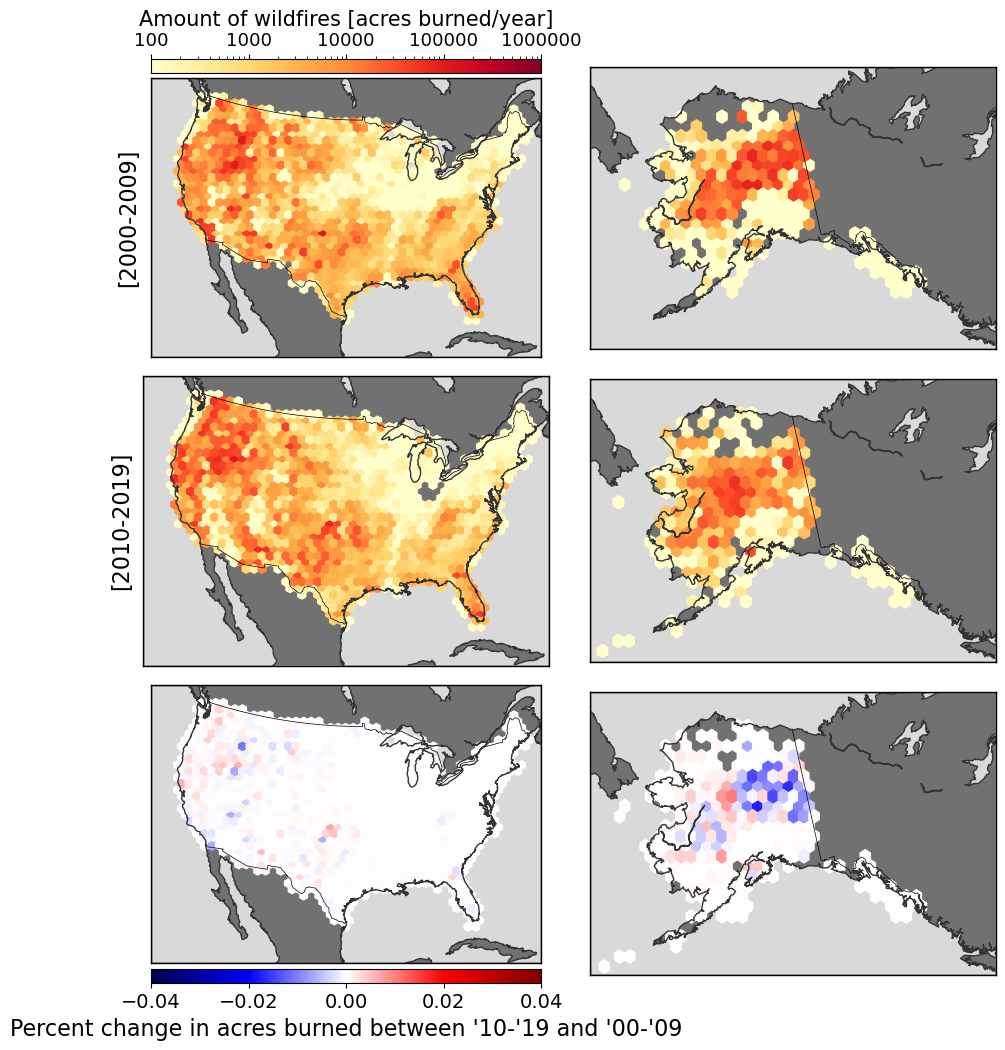

In [6]:
# lat & long pairs for the lower left and upper right corners, respectively
cUS_corners = [-120, 18, -62, 50];
AK_corners = [-170, 52, -105, 65]

# centering lat. and long.
cUS_ll0 = [40, -95]
AK_ll0 = [62.5, -155]

# gridsize argument to hexbin for each data set
# Manually adjusted until land per hex is roughly equal in each
# map, see prints at the bottom of the cell
cUS_hexgrid = [46,18]; AK_hexgrid = [40,12]; AK_hexgrid2 = [29,12];
cblimits = [100,1000000]
cblimits_diff = [-0.04, 0.04]

fig, axs = plt.subplots(3,2, figsize=[11,12])
plt.subplots_adjust(wspace = 0.1, hspace=0.05)

bColourbar = True
plt.axes(axs[0,0])
norm = 10 # normalization: 10 years, to get data as per annum.
hex_cUS_00_10 = pltrs.plot_hexbin_frame( conUS_00_10, norm,
    cUS_corners, cUS_ll0, cUS_hexgrid,
    bColourbar, cblimits)
plt.ylabel('[2000-2009]', fontsize=16)

bColourbar = False
plt.axes(axs[0,1])
hex_AK_00_10 = pltrs.plot_hexbin_frame( AK_00_10, norm,
    AK_corners, AK_ll0, AK_hexgrid,
    bColourbar, cblimits)

"""
# Check that the sum of hexbin 2D histogram values equals
# the sum of the FIRE_SIZE from the raw data
# From this print I caught that the default function hexbin()
# uses to ammalgamate given colour values is mean, not sum!
print("sum check:", AK_00_10['FIRE_SIZE'].sum()/norm,
      np.sum(hex_AK_00_10.get_array()))
"""

plt.axes(axs[1,0])
hex_cUS_10_20 = pltrs.plot_hexbin_frame( conUS_10_20, norm,
    cUS_corners, cUS_ll0, cUS_hexgrid,
    bColourbar, cblimits)
plt.ylabel('[2010-2019]', fontsize=16)

plt.axes(axs[1,1])
hex_AK_10_20 = pltrs.plot_hexbin_frame( AK_10_20, norm,
    AK_corners, AK_ll0, AK_hexgrid2,
    bColourbar, cblimits)

bColourbar = True
plt.axes(axs[2,0])

norm = 20*np.sum(hex_cUS_00_10.get_array())
# 20 years, and then the sum of all fires from '00-'09, to get % change
hdiff_cUS = pltrs.plot_hexbin_frame_diff( conUS_00_20, norm,
    cUS_corners, cUS_ll0, cUS_hexgrid,
    bColourbar, cblimits_diff)

bColourbar = False
plt.axes(axs[2,1])
norm = 20*np.sum(hex_AK_00_10.get_array())
hdiff_AK = pltrs.plot_hexbin_frame_diff( AK_00_20, norm,
    AK_corners, AK_ll0, AK_hexgrid,
    bColourbar, cblimits_diff)

"""
AK_area = 0.663 # Million sq. mi.
cUS_area = 3.119 # Million sq. mi.
print("Hex and Area ratios:")
print("Land Area: {:.3f} ; Con. US.: {:.3f} ; Alaska(1): {:.3f}; Alaska(2): {:.3f}".
      format( cUS_area/AK_area,
    hex_cUS_00_10.get_array().shape[0]/hex_cUS_10_20.get_array().shape[0],
    hex_cUS_00_10.get_array().shape[0]/hex_AK_00_10.get_array().shape[0],
    hex_cUS_00_10.get_array().shape[0]/hex_AK_10_20.get_array().shape[0]))
# Wanted to confirm the hexes in both plots represent roughly the same area
# Checking that ratio of land area is same to ratio of number of hexes
# Played with the hex grid variables until this was true
"""

plt.show()

5260845.208568301 1892344.2432189998


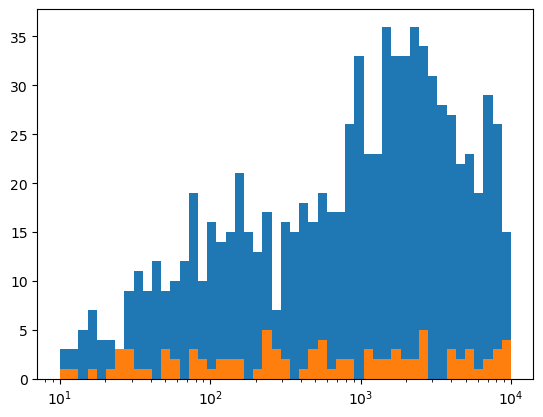